In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

TrainingData_dir = "./Phase1Labeled"

# get the file name in dict

In [23]:
file_dicts=[]
for idx, file in enumerate(os.listdir(TrainingData_dir)):
    file_path = os.path.join(TrainingData_dir, file)
    if not os.path.isdir(file_path):
        continue
    truthDataFile = os.path.join(file_path, "TruthData.mat")
    sensorDataFile = os.path.join(file_path, "SensorData.mat")
    file_dicts.append({"file":file, "truthDataFile":truthDataFile, "sensorDataFile":sensorDataFile})

In [24]:
len(file_dicts)

9

In [25]:
file_dicts[0]

{'file': '1_iter_batchfile_Fault_5_agc_0_attack_NoAttack',
 'truthDataFile': './Phase1Labeled/1_iter_batchfile_Fault_5_agc_0_attack_NoAttack/TruthData.mat',
 'sensorDataFile': './Phase1Labeled/1_iter_batchfile_Fault_5_agc_0_attack_NoAttack/SensorData.mat'}

In [26]:
def get_truth_data(truthDataFile):
    truthDict = loadmat(truthDataFile)
    truth = np.transpose(truthDict["AttackTruth"][0])
    return truth

In [27]:
def make_sliding_window(X, y, window_size, stride):
    X_seq = []
    y_seq = []

    for i in range(0, len(X) - window_size + 1, stride):
        x_window = X[i:i+window_size]     # shape: (window_size, D)
        y_window = y[i:i+window_size]     # shape: (window_size, num_classes)

        x_flat = x_window.flatten()       # shape: (window_size * D,)

        # Sum across time dimension (rows) → vector of class counts
        class_counts = np.sum(y_window, axis=0)  # shape: (num_classes,)

        # Get the index (class) with the most 1's

        X_seq.append(x_flat)
        y_seq.append(class_counts)
        
    X_seq = np.stack(X_seq)  # shape: (num_windows, window_size * D)
    y_label = np.argmax(y_seq)  # shape: (num_windows,)
    return X_seq, y_label


# convert the data and label into sliding window 

In [32]:
vol=[]
y_label=[]
for _file_dict in  file_dicts:
    sensorDataFile=_file_dict["sensorDataFile"]
    sensorDict = loadmat(sensorDataFile)
    pmu_va = sensorDict["PMU_Va"]
    pmu_vm = sensorDict["PMU_Vm"]
    pmu_f = sensorDict["PMU_f"]
    pmu_vm_normalized = MinMaxScaler().fit_transform(pmu_vm)
    label=get_truth_data(_file_dict["truthDataFile"])
    Xseq,yseq=make_sliding_window(pmu_vm_normalized,label, window_size = 5,stride = 5)
    y_label.append(yseq)
    vol.append(Xseq)


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_heads, n_layers, num_timesteps,drop_out):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, num_timesteps, hidden_dim))
        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=n_heads, num_encoder_layers=n_layers, num_decoder_layers=n_layers)
        self.fc = nn.Linear(hidden_dim * num_timesteps, output_dim)  # Flatten the output of the transformer
        self.dropout = nn.Dropout(p=drop_out)
        self.bn = nn.BatchNorm1d(hidden_dim * num_timesteps)

    def forward(self, src):
        src_emb = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # (seq_len, batch, feature)
        transformer_output = self.transformer.encoder(src_emb)
        transformer_output = transformer_output.permute(1, 0, 2).contiguous().view(src.size(0), -1)  # Flatten
        transformer_output = self.bn(transformer_output)
        transformer_output = self.dropout(transformer_output)
        predictions = self.fc(transformer_output)
        return predictions
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [56]:
# Convert to PyTorch tensors
X = torch.tensor(np.array(vol), dtype=torch.float32)
y = torch.tensor(np.array(y_label))

# Extract dataset details
num_samples = len(X)
num_timesteps = len(X[0])
num_features = len(X[0][0])
num_class = torch.max(y)+1
#num_class=2


In [97]:
y

tensor([  0,   0, 439,   0,  46,   0,   0,   0, 980])

In [57]:
num_class

tensor(981)

In [103]:
# Define input and output dimensions (example placeholders)
input_dim = num_features
hidden_dim = 128
output_dim = num_class
n_heads = 2
n_layers = 2


# Initialize model, loss function, and optimizer
model = TransformerClassifier(input_dim, hidden_dim, output_dim, n_heads, n_layers, num_timesteps,drop_out=0.3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Create DataLoader
data = TensorDataset(X, y)
loader = DataLoader(data, batch_size=32, shuffle=True)


# Train the model
reset_weights(model)
model.train()
for epoch in range(40):
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Training loop
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(loader)

    # Print metrics for this epoch
    print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}')
# Save the trained model
model_path = 'Attack_detector.pth'
torch.save(model.state_dict(), model_path)
print(f'=============\nModel saved to {model_path}\n=============')

print('=============\n finished training\n=============')

/Users/joshem/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1: Train Loss = 7.0347
Epoch 2: Train Loss = 23.9215
Epoch 3: Train Loss = 8.5476
Epoch 4: Train Loss = 10.1521
Epoch 5: Train Loss = 4.0240
Epoch 6: Train Loss = 1.0518
Epoch 7: Train Loss = 0.0005
Epoch 8: Train Loss = 1.4408
Epoch 9: Train Loss = 0.0285
Epoch 10: Train Loss = 0.0008
Epoch 11: Train Loss = 0.8301
Epoch 12: Train Loss = 0.0862
Epoch 13: Train Loss = 0.0001
Epoch 14: Train Loss = 0.0000
Epoch 15: Train Loss = 0.5702
Epoch 16: Train Loss = 0.0001
Epoch 17: Train Loss = 0.0000
Epoch 18: Train Loss = 0.0025
Epoch 19: Train Loss = 0.0010
Epoch 20: Train Loss = 0.2871
Epoch 21: Train Loss = 0.0000
Epoch 22: Train Loss = 0.0000
Epoch 23: Train Loss = 0.0000
Epoch 24: Train Loss = 0.4853
Epoch 25: Train Loss = 0.0000
Epoch 26: Train Loss = 0.0001
Epoch 27: Train Loss = 0.0000
Epoch 28: Train Loss = 0.3619
Epoch 29: Train Loss = 0.0023
Epoch 30: Train Loss = 0.0000
Epoch 31: Train Loss = 0.0000
Epoch 32: Train Loss = 0.0000
Epoch 33: Train Loss = 0.0000
Epoch 34: Train L

# Evaluation

In [140]:
EvaluationData_dir = "./dataset/Evaluation/Phase1Evaluation"
#EvaluationData_dir = "./EvaluationData"
folder_dicts=[]
for idx, folder in enumerate(os.listdir(EvaluationData_dir)):
    folder_path = os.path.join(EvaluationData_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    sensorDataFile = os.path.join(folder_path, "SensorData.mat")
    folder_dicts.append({"file":folder, "sensorDataFile":sensorDataFile})

In [141]:
len(folder_dicts)

759

In [142]:
folder_dicts[0]

{'file': '07cc07e5-ad8c-4bab-8435-f0ee7f07e1f8',
 'sensorDataFile': './dataset/Evaluation/Phase1Evaluation/07cc07e5-ad8c-4bab-8435-f0ee7f07e1f8/SensorData.mat'}

In [110]:
def attack_detector(sensorDataFile,model):
    sensorDict = loadmat(sensorDataFile)
    pmu_va = sensorDict["PMU_Va"]
    pmu_vm = sensorDict["PMU_Vm"]
    pmu_f = sensorDict["PMU_f"]
    pmu_vm_normalized = MinMaxScaler().fit_transform(pmu_vm)
    Xseq,yseq=make_sliding_window(pmu_vm_normalized,label, window_size = 5,stride = 5)
    X = torch.tensor(Xseq, dtype=torch.float32)
    # Test on new data
    with torch.no_grad():
        new_output = model(X.unsqueeze(0))  # new_X should be preprocessed like the original training data
        #print(len(new_output[0]))
        _, new_predictions = torch.max(new_output, 1)
        print(new_predictions)
        #probs = torch.sigmoid(new_output)
        one_hot_label = np.zeros(num_class)
        if new_predictions!=0:
            one_hot_label[new_predictions] = 0.99
    upsampled_preds = np.repeat(one_hot_label, repeats=5, axis=0)
    return upsampled_preds

In [143]:
# Define input and output dimensions (example placeholders)
input_dim = num_features
hidden_dim = 128
output_dim = 1200
num_class=1200
n_heads = 2
n_layers = 2
# Re-initialize the model with the same architecture
model = TransformerClassifier(input_dim, hidden_dim, output_dim, n_heads, n_layers, num_timesteps,drop_out=0.3)

# Load the saved model weights
#model.load_state_dict(torch.load('Attack_detector.pth'))
model.load_state_dict(torch.load('Attack_detector_single1.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode
detection_dict={}
for _file_dict in  folder_dicts:
    detection_dict[_file_dict["file"]]=attack_detector(_file_dict["sensorDataFile"],model)

/Users/joshem/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/var/folders/k8/fv2pzvcn5p77dgds_c16lsl80000gn/T/ipykernel_74301/222385940.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects wi

tensor([897])
tensor([445])
tensor([594])
tensor([445])
tensor([594])
tensor([940])
tensor([897])
tensor([869])
tensor([897])
tensor([97])
tensor([897])
tensor([897])
tensor([68])
tensor([940])
tensor([594])
tensor([184])
tensor([594])
tensor([897])
tensor([868])
tensor([897])
tensor([897])
tensor([897])
tensor([897])
tensor([445])
tensor([315])
tensor([869])
tensor([445])
tensor([97])
tensor([940])
tensor([594])
tensor([869])
tensor([940])
tensor([869])
tensor([594])
tensor([594])
tensor([118])
tensor([897])
tensor([869])
tensor([897])
tensor([594])
tensor([897])
tensor([985])
tensor([897])
tensor([1125])
tensor([897])
tensor([897])
tensor([861])
tensor([594])
tensor([897])
tensor([897])
tensor([940])
tensor([940])
tensor([733])
tensor([869])
tensor([869])
tensor([493])
tensor([897])
tensor([940])
tensor([897])
tensor([897])
tensor([97])
tensor([897])
tensor([940])
tensor([897])
tensor([912])
tensor([159])
tensor([897])
tensor([897])
tensor([897])
tensor([897])
tensor([897])
tensor([8

tensor([897])
tensor([869])
tensor([897])
tensor([897])
tensor([897])
tensor([897])
tensor([897])
tensor([245])
tensor([337])
tensor([897])
tensor([940])
tensor([594])
tensor([897])
tensor([189])
tensor([899])
tensor([869])
tensor([143])
tensor([940])
tensor([897])
tensor([940])
tensor([897])
tensor([594])
tensor([897])
tensor([1175])
tensor([143])
tensor([897])
tensor([143])
tensor([869])
tensor([869])
tensor([940])
tensor([899])
tensor([772])
tensor([869])
tensor([720])
tensor([869])
tensor([897])
tensor([143])
tensor([940])
tensor([594])
tensor([940])
tensor([940])
tensor([940])
tensor([807])
tensor([594])
tensor([159])
tensor([897])
tensor([868])
tensor([940])
tensor([869])
tensor([594])
tensor([869])
tensor([897])
tensor([97])
tensor([897])
tensor([594])
tensor([869])
tensor([899])
tensor([869])
tensor([897])
tensor([897])
tensor([940])
tensor([940])
tensor([1064])
tensor([594])
tensor([515])
tensor([594])
tensor([897])
tensor([720])
tensor([940])
tensor([897])
tensor([869])
tenso

In [144]:
detection_df=pd.DataFrame.from_dict(detection_dict)
detection_df

,07cc07e5-ad8c-4bab-8435-f0ee7f07e1f8,1af0eb33-4337-47c4-87be-055dec2aa124,1eaa95ba-e720-42d5-a7ae-98fe220614d6,a1f4cd73-1379-4064-a367-b47064ec1207,366d3d57-e6df-481c-a81d-9047ca5271a6,91b88640-68b0-4c55-ae11-fe2b8b0d1934,3231c2ce-f486-4e36-a490-dadd96a30378,2e0fd414-f116-42a7-85f5-06e126c728ea,31dfc8aa-65f7-4e53-bdb3-97fce9624a05,43a4bff7-f0a4-45ad-b74f-b6b0c0bad64f,...,d1919de7-5334-4701-acce-11b9be0a4fe9,88812316-3330-404d-bc80-fda67cba88fb,62d16bb5-53c1-4abd-8692-a9e3f1250707,ebd19fcd-bcf7-4a55-817b-36c92f0bc9e1,7cac1a2e-f6c4-4c28-814c-245e2cf3b22a,6b735478-4b24-4dfa-a7e3-51977cad79ee,8ee4bc55-ea26-4b5b-a77f-4ad1cfa0d3e6,4e1a5dc7-4323-4c40-a6ba-fb73f42b81c3,b46c95a1-66b4-4a77-8d86-ab6bc8566eea,b49de503-7da2-40f6-8ffa-2f17ba81861b
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
pre=list(detection_dict.values())[200]

In [150]:
for i in range(len(pre)):
    if pre[i] != 0:
        print(pre[i], i)

0.99 4345
0.99 4346
0.99 4347
0.99 4348
0.99 4349


In [123]:
# Create csvs
detection_df.to_csv("DetectionDataFrame.csv")

In [151]:
df = pd.read_csv('DetectionDataFrame.csv')

In [163]:
test=list(df['07cc07e5-ad8c-4bab-8435-f0ee7f07e1f8'])
for i in range(len(test)):
    if test[i] != 0:
        print(test[i], i)

0.99 4485
0.99 4486
0.99 4487
0.99 4488
0.99 4489


In [ ]:
def reconstruct_predictions(preds, window_size, stride, total_timesteps):
    """
    preds: (N, num_classes) - model predictions per window
    returns: (total_timesteps, num_classes) - averaged predictions per original timestep
    """
    num_classes = preds.shape[1]
    vote_sums = np.zeros((total_timesteps, num_classes))
    vote_counts = np.zeros((total_timesteps, 1))

    for i, window_pred in enumerate(preds):
        start = i * stride
        end = start + window_size
        vote_sums[start:end] += window_pred  # broadcast
        vote_counts[start:end] += 1

    averaged_preds = vote_sums / np.maximum(vote_counts, 1)
    return averaged_preds


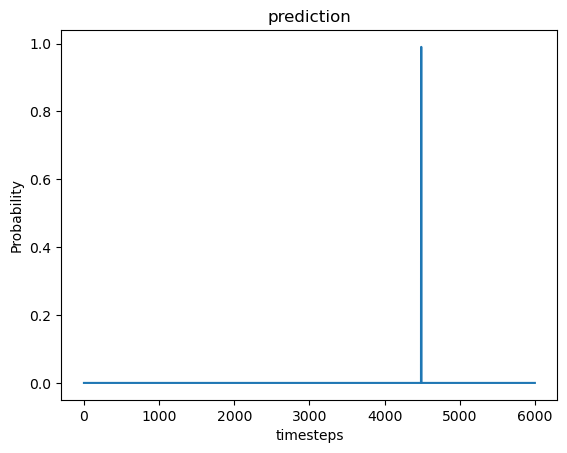

In [129]:
plt.plot(list(detection_dict.values())[0])
plt.title("prediction")
plt.xlabel("timesteps")
plt.ylabel("Probability")
plt.show()

In [ ]:
pre=list(detection_dict.values())[0]